<a href="https://colab.research.google.com/github/drscook/m5364_19fl_Data_Mining1/blob/master/DM2/Intro_to_Rudimentary_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Define functions for later use

import numpy as np
import matplotlib.pyplot as plt
import itertools as it

# min-max-scaler
def min_max_scale(y):
    a = np.min(y)
    r = np.max(y) - a
    def scaler(y):
        return (y - a) / r
    def unscaler(z):
        return z * r + a
    return scaler, unscaler


# common activation functions and their derivatives
def id():
    def f(x):
        return x.copy()
    def df(x):
        return np.ones_like(x)
    return f, df

def relu():
    def f(x):
        y = x.copy()
        y[y<0] = 0.0
        return y
    def df(x):
        return (x>0).astype(float)
    return f, df

def sigmoid():
    def f(x):
        return 1 / (1 + np.exp(-x))
    def df(x):
        return np.exp(-x) / (1 + np.exp(-x))**2
    return f, df

def tanh():
    def f(x):
        y = np.tanh(x)  # range is [-1, 1]
        return y / 2 + 1/2  # scales so range is [0,1]
    def df(x):
        dy = 1 - np.tanh(x)**2  # derivative of tanh
        return y / 2 + 0  # scaling factor from above
    return f, df

def arctan():
    def f(x):
        y = np.arctan(x)  # range is [-pi/2, pi/2]
        return y / np.pi + 1/2  # scales so range is [0,1]
    def df(x):
        y = 1 / (1 + x**2)  # derivative of arctan
        return y / np.pi  # scaling factor from above
    return f, df

def mse_cost():
    def f(e):
        return (e**2).sum() / (2 * n)
    def df(e):
        return e / n
    return f, df


def setup_ANN():
    n, p = feat.shape
    m, q = targ.shape
    if m != n:
        raise Exception('feat and targ must have the same number of rows')

    nodes = [p] + hidden_nodes + [q]
    layers = len(nodes)

    cost, dcost = mse_cost()
    f, df = activation()
    f = [f for l in range(layers)]
    df = [df for l in range(layers)]
    f[0], df[0] = id()

    X, DCDX, Y, DCDY, B, DCDB, W, DCDW = pre_allocate(n, nodes)
    return n, p, m, q, nodes, layers, cost, dcost, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW


def pre_allocate(n, nodes):
    ## pre-allocate variables

    ## X[l,i,j] = input to node j of layer l for observation i; X[l] has shape (n, nodes[l])
    X = [np.zeros(shape=[n,p]) for p in nodes]

    ## DCDX[l,i,j] = partial derivative of cost wrt X[l,i,j]; DCDX[l] has shape (n, nodes[l])
    DCDX = [np.zeros_like(x) for x in X]

    ## Y[l,i,j] = output from node j of layer l for observation i; Y[l] has shape (n, nodes[l])
    Y = [np.zeros(shape=[n,p]) for p in nodes]

    ## DCDY[l,i,j] = partial derivative of cost wrt Y[l,i,j]; DCDY[h] has shape (n, nodes[l])
    DCDY = [np.zeros_like(y) for y in Y]

    ## B[l,k] = bias into node k of layer l+1; B[l] has shape nodes[l+1]
    B = [rnd.rand(p) for p in nodes[1:]]

    ## DCDB[l,k] = partial derivative of cost wrt B[l,k]; DCDB[l] has shape nodes[l+1]
    DCDB = [np.zeros_like(b) for b in B]
    
    ## W[l,j,k] = weight of edge from node j of layer l to node k of layer l+1; W[l] has shape (nodes[l], nodes[l+1])
    W_sh = [(i,o) for (i,o) in zip(nodes[:-1], nodes[1:])]  ## Generate shapes for W
    W = [rnd.rand(*s) for s in W_sh]
    
    ## DCDW[l,j,k] = partial derivative of cost wrt W[l,j,k]; DCDW[l] has shape (nodes[l], nodes[l+1])
    DCDW = [np.zeros_like(w) for w in W]

    return X, DCDX, Y, DCDY, B, DCDB, W, DCDW


def train_ANN(feat, targ, X, DCDX, Y, DCDY, B, DCDB, W, DCDW):
    cost_hist = []
    for step in range(max_steps):
        X[0] = feat.copy()
        forward_propagate(X, Y)
        E = Y[-1] - targ  # note: choice of t-p vs p-t may impact the +/- sign in descend_gradient
        C = cost(E)
        cost_hist.append(C)
        if step % report_period == 0:
            print(f"step {step} cost = {C}")

        # Check if good enough to stop now
        if C < 1e-3:
            print(f"Terminate at step {step} cost = {C}")
            break

        backward_propagate(DCDX, DCDY, DCDB, DCDW, E)
        descend_gradient(B, W)
    return cost_hist


def forward_propagate(X, Y):
    for l in range(layers-1):
        Y[l] = f[l](X[l])
        X[l+1] = Y[l] @ W[l] + B[l]
    l += 1
    Y[l] = f[l](X[l])


def backward_propagate(DCDX, DCDY, DCDB, DCDW, E):
    DCDY[-1] = dcost(E)
    for l in reversed(range(layers-1)):
        DCDX[l+1] = DCDY[l+1] * df[l+1](X[l+1])
        DCDY[l]   = np.einsum('ik,jk->ij', DCDX[l+1], W[l])
        DCDW[l]   = np.einsum('ik,ij->jk', DCDX[l+1], Y[l])
        DCDB[l]   = np.einsum('ik->k'    , DCDX[l+1])
        

def descend_gradient(B, W):
    # Compute magnitude of gradient - square all entries of DCDB & DCDW, add, sqrt
    # We must do list comprehension over each layer b/c layers are not the same size
    m = np.sqrt(np.sum([np.sum(B**2) + np.sum(W**2) for B,W in zip(DCDB, DCDW)]))
    for l in range(layers-1):
        B[l] -= DCDB[l] / m * learn_rate
        W[l] -= DCDW[l] / m * learn_rate

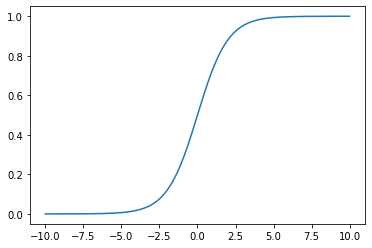

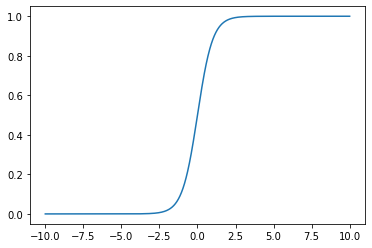

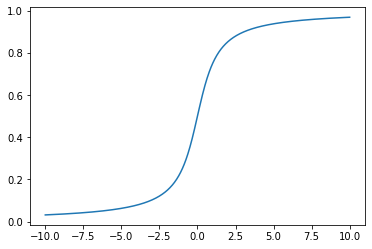

In [16]:
# Verify that ranges of bounded activation functions really are [0,1]
x = np.linspace(-10,10,1000)
for f in [sigmoid, tanh, arctan]:
    plt.plot(x, f()[0](x))
    plt.show()

step 0 cost = 0.13864953382541412
step 10000 cost = 0.0015769100480732177
step 20000 cost = 0.0005449463740385474
step 30000 cost = 0.0003686439514577274
step 40000 cost = 0.000304686894551676


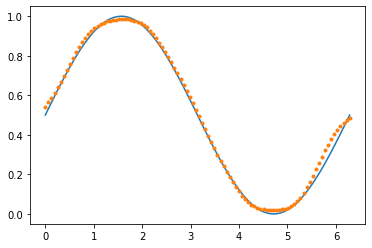

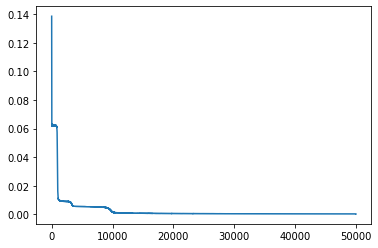

CPU times: user 24.8 s, sys: 8.52 ms, total: 24.8 s
Wall time: 24.9 s


In [25]:
## Build Feedforward ANN to approximate f(x)=e^(-x^2)
%%time
rnd = np.random.RandomState(42)


## Set Hyperparameters
hidden_nodes = [10,5,3]# list of node counts for each hidden layer
# activation = relu
activation = sigmoid
# activation = tanh
# activation = arctan

max_steps = 50000
learn_rate = 0.1
report_period = 10000


## Get data
feat = np.sort(np.linspace(0, 2*np.pi, 100))[:, np.newaxis]
def f(x):
    return np.sin(x)
y = f(feat)
y_scaler, y_unscaler = min_max_scale(y)
targ = scaler(y)


## Setup & Train ANN
n, p, m, q, nodes, layers, cost, dcost, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW = setup_ANN()
cost_hist = train_ANN(feat, targ, X, DCDX, Y, DCDY, B, DCDB, W, DCDW)


## Results
fig = plt.plot()
plt.plot(feat, targ)
plt.plot(feat, Y[-1], '.')
plt.show()

fig = plt.plot()
plt.plot(cost_hist)
plt.show()

In [0]:
## example from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/, use sigmoid, cost=(e**2)/2
%%time
rnd = np.random.RandomState(42)


## Set Hyperparameters
hidden_nodes = [2]  # list of node counts for each hidden layer
activation = sigmoid
learn_rate = 0.5
max_steps = 1
report_period = 1


## Get data
feat = np.array([[.05,.1]])
targ = np.array([[.01,.99]])


## Setup & Train ANN
n, p, m, q, nodes, layers, cost, dcost, f, df, X, DCDX, Y, DCDY, B, DCDB, W, DCDW = setup_ANN()

## example from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/, use sigmoid activtion & square cost=(e**2)/(2n)
W = [np.array([[0.15, 0.25], [0.20, 0.30]]),
     np.array([[0.40, 0.50], [0.45, 0.55]])]

cost_hist = train_ANN(feat, targ, X, DCDX, Y, DCDY, B, DCDB, W, DCDW)


## Results
for l in range(layers):
    print(f"layer = {l}")
    print("X")
    print(X[l])
    print("Y")
    print(Y[l])
    if l < layers-1:
        print("W")
        print(W[l])
        print("B")
        print(B[l])

    print()

step 0 cost = 0.3218208039242589
layer = 0
X
[[0.05 0.1 ]]
Y
[[0.05 0.1 ]]
W
[[0.14886932 0.24894401]
 [0.19773864 0.29788801]]
B
[0.35192656 0.92959445]

layer = 1
X
[[0.40204012 0.99321431]]
Y
[[0.59917772 0.72972234]]
W
[[0.18975689 0.55535867]
 [0.1939506  0.61741983]]
B
[0.38110788 0.69104956]

layer = 2
X
[[1.30004008 1.29959463]]
Y
[[0.78584173 0.78576675]]

CPU times: user 6.22 ms, sys: 2.15 ms, total: 8.37 ms
Wall time: 6.87 ms
